In [90]:
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Dropout, BatchNormalization, LSTM, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.losses import Huber
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal

In [91]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [92]:
df_forFCST = pd.read_csv(  r'/content/gdrive/MyDrive/DataStore/salesD_smoothed.csv' )
df_forFCST.set_index( 'ds', inplace = True )
df_forFCST.index = pd.to_datetime( df_forFCST.index )
df_forFCST.index

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10',
               ...
               '2024-06-21', '2024-06-22', '2024-06-23', '2024-06-24',
               '2024-06-25', '2024-06-26', '2024-06-27', '2024-06-28',
               '2024-06-29', '2024-06-30'],
              dtype='datetime64[ns]', name='ds', length=2008, freq=None)

In [93]:
def get_model(input_shape, wd = 3e-3, dp = 0.5):
    model = Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      activation="relu",
                      input_shape=input_shape, kernel_initializer=HeNormal()),
  tf.keras.layers.LSTM(64, return_sequences=True, kernel_regularizer=l2(wd)),
        Dropout(dp),
  tf.keras.layers.LSTM(64, return_sequences=True, kernel_regularizer=l2(wd)),
        Dropout(dp),
  tf.keras.layers.LSTM(64, return_sequences=True, kernel_regularizer=l2(wd)),
  tf.keras.layers.LSTM(64, kernel_regularizer=l2(wd)),
  tf.keras.layers.Dense(1)
    ])
    return model



In [94]:
def get_compile(model, lrate = 6e-4):
    optimizer = tf.keras.optimizers.SGD(momentum=0.9, learning_rate=lrate)

    model.compile(optimizer=optimizer,
              loss='mae',
                #loss = 'mae',
                  metrics = ['mae', 'mse'])

def get_checkpoint_every_epoch():
    return ModelCheckpoint(
        filepath='/content/gdrive/MyDrive/var/FTryModel/checkpoints_every_epoch/checkpoint_{epoch:03d}.weights.h5',
        save_weights_only=True,
        save_freq='epoch',
    )

def get_checkpoint_best_only():
    return ModelCheckpoint(
        filepath='/content/gdrive/MyDrive/var/FTryModel/checkpoints_best_only/checkpoint.weights.h5',
        save_weights_only=True,
        monitor='loss',
        save_best_only=True,
        mode='min',
    )

def get_early_stopping():
    return EarlyStopping(monitor='loss', patience=100, mode='min', min_delta=0.005)
def get_lr_schedule():
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 2e-9 * 10**(epoch / 20))
    return lr_schedule

def get_test_accuracy(model, x_test, y_test):
    test_loss, test_mse, test_mae = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('losses: {acc:0.3f}'.format(acc=test_loss))
    print('mse: {acc:0.3f}'.format(acc=test_mse))
    print('mae: {acc:0.3f}'.format(acc=test_mae))
    predictions = model.predict(x_test)
    print('deviation:', abs((sum(predictions) - sum(y_test))) / sum(y_test), '%')
    plt.plot(y_test, label='Фактические продажи')
    plt.plot(predictions, label='Предсказанные продажи')
    #plt.plot(val_loss, label='Валидация')
    plt.legend()
    plt.show()
def get_test_results(model, x_test, y_test):
    test_loss, test_mse, test_mae = model.evaluate(x=x_test, y=y_test, verbose=0)
    predictions = model.predict(x_test, verbose = 0)
    return test_loss, test_mse, test_mae, (abs((sum(predictions) - sum(y_test))) / sum(y_test))

In [95]:
features = ['y_mix', 'y_wo', 'coef']

# Создание лагов
look_back = 10  # Размер окна наблюдения
df_forFCST['y_mix_lag1'] = df_forFCST['y_mix'].shift(1)
df_forFCST['y_wo_lag1'] = df_forFCST['y_wo'].shift(1)
df_forFCST['coef_lag1'] = df_forFCST['coef'].shift(1)
features.extend(['y_mix_lag1', 'y_wo_lag1', 'coef_lag1'])

# Удаление пропущенных значений
df_forFCST.dropna(inplace=True)

scaler = MinMaxScaler()
df_forFCST[features] = scaler.fit_transform(df_forFCST[features])
print(len(df_forFCST))
# Разделение данных
train_size = int(len(df_forFCST) * 0.9)
train_data = df_forFCST[:train_size]
val_data = df_forFCST[train_size:train_size + int(len(df_forFCST) * 0.05)]
test_data = df_forFCST[train_size + int(len(df_forFCST) * 0.05):]



# Создание обучающих данных
def create_dataset(data, look_back):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back), :]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 10
X_train, y_train = create_dataset(train_data[features].values, look_back)
X_val, y_val = create_dataset(val_data[features].values, look_back)
X_test, y_test = create_dataset(test_data[features].values, look_back)

2007


In [96]:
input_shape=(X_train.shape[1], X_train.shape[2])

checkpoint_every_epoch = get_checkpoint_every_epoch()
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()
lr_shed = get_lr_schedule()
callbacks = [checkpoint_every_epoch, checkpoint_best_only, early_stopping]
#callbacks = [lr_shed]

In [97]:
model = get_model(input_shape)
get_compile(model)
model.summary()

batchs = 50

history = model.fit(X_train, y_train, epochs = 25, verbose = 2, validation_data = (X_val, y_val), batch_size = batchs)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_21 (Conv1D)                   │ (None, 8, 64)               │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_88 (LSTM)                       │ (None, 8, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 8, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_89 (LSTM)                       │ (None, 8, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 8, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_90 (LSTM)                       │ (None, 8, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_91 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 133,377 (521.00 KB)

 Trainable params: 133,377 (521.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
36/36 - 11s - 299ms/step - loss: 1.4867 - mae: 0.2544 - mse: 0.0921 - val_loss: 1.4173 - val_mae: 0.1863 - val_mse: 0.0439
Epoch 2/25
36/36 - 3s - 90ms/step - loss: 1.3843 - mae: 0.1549 - mse: 0.0354 - val_loss: 1.4080 - val_mae: 0.1802 - val_mse: 0.0444
Epoch 3/25
36/36 - 1s - 25ms/step - loss: 1.3788 - mae: 0.1526 - mse: 0.0356 - val_loss: 1.4038 - val_mae: 0.1792 - val_mse: 0.0432
Epoch 4/25
36/36 - 1s - 35ms/step - loss: 1.3749 - mae: 0.1518 - mse: 0.0350 - val_loss: 1.4007 - val_mae: 0.1792 - val_mse: 0.0434
Epoch 5/25
36/36 - 1s - 35ms/step - loss: 1.3721 - mae: 0.1522 - mse: 0.0353 - val_loss: 1.3973 - val_mae: 0.1790 - val_mse: 0.0431
Epoch 6/25
36/36 - 1s - 35ms/step - loss: 1.3686 - mae: 0.1518 - mse: 0.0355 - val_loss: 1.3942 - val_mae: 0.1790 - val_mse: 0.0433
Epoch 7/25
36/36 - 1s - 25ms/step - loss: 1.3655 - mae: 0.1519 - mse: 0.0352 - val_loss: 1.3906 - val_mae: 0.1786 - val_mse: 0.0426
Epoch 8/25
36/36 - 1s - 26ms/step - loss: 1.3619 - mae: 0.1514 - mse: 0.03

losses: 1.332
mse: 0.175
mae: 0.043
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step
deviation: [0.0168781] %


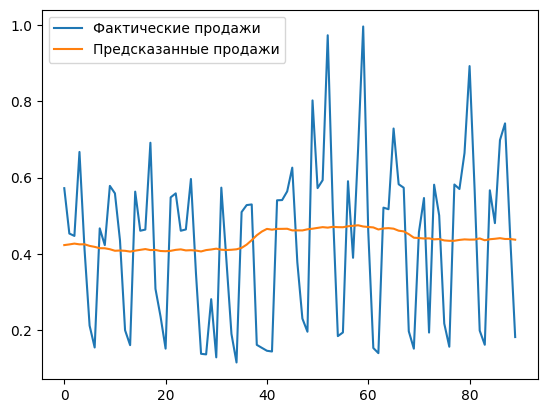

losses: 1.296
mse: 0.139
mae: 0.027
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
deviation: [0.01996112] %


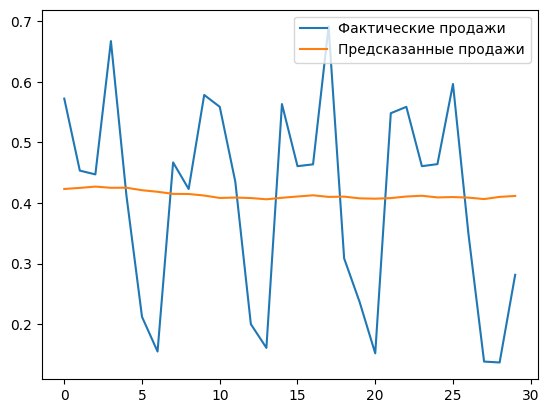

losses: 1.361
mse: 0.204
mae: 0.057
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
deviation: [0.03512097] %


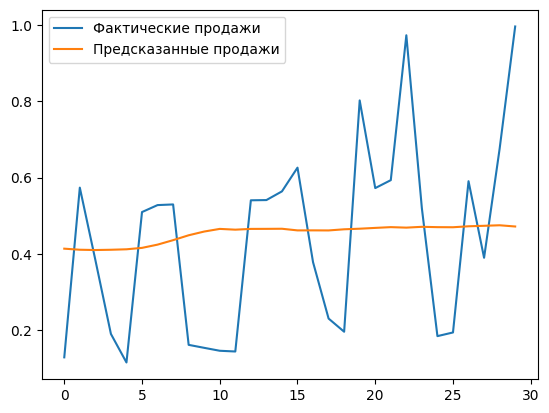

losses: 1.339
mse: 0.182
mae: 0.046
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
deviation: [0.0037432] %


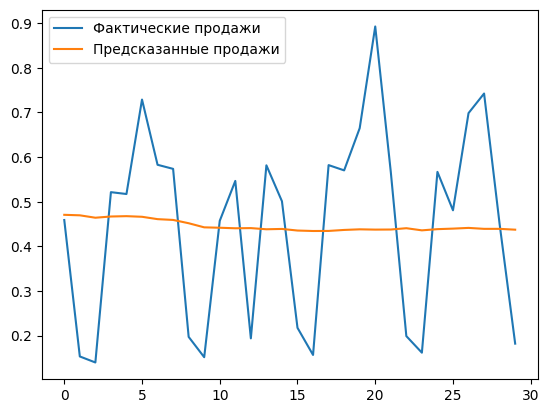

In [98]:
get_test_accuracy(model, X_test, y_test)
#get_test_accuracy(model, X_test[-31: -1], y_test[-31:-1])
#get_test_accuracy(model, X_test[-61: -31], y_test[-61:-31])
#get_test_accuracy(model, X_test[-91: -61], y_test[-91:-61])
#get_test_accuracy(model, X_test[-121: -91], y_test[-121:-91])
get_test_accuracy(model, X_test[0: 30], y_test[0: 30])
get_test_accuracy(model, X_test[30: 60], y_test[30: 60])
get_test_accuracy(model, X_test[60: 90], y_test[60: 90])

<Axes: >

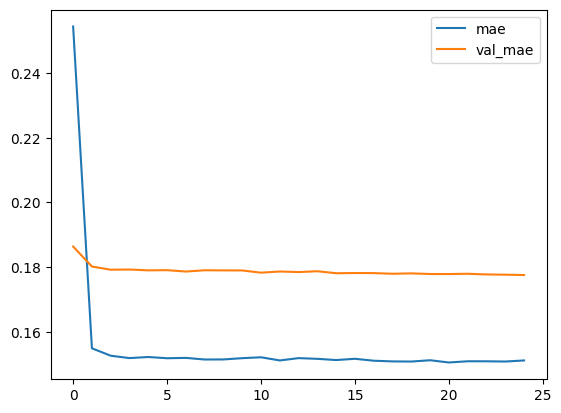

In [101]:
df = pd.DataFrame(history.history)
df.plot(y=['mae', 'val_mae'])

In [100]:
batchsi = [32, 50]
lratesi = [6e-4, 8e-4, 1e-3, 2e-3, 3e-3, 4e-3]
weedi = [6e-4, 8e-4, 1e-3, 2e-3, 3e-3]
dpi = [0.4, 0.45, 0.5, 0.6]
bests = []

**доп**

In [ ]:
for batchs in batchsi:
    for lrate in lratesi:
        for weed in weedi:
            for dp in dpi:
                model = get_model(input_shape, weed, dp)
                get_compile(model, lrate)
                history = model.fit(X_train, y_train, epochs=25, verbose = 0, batch_size = batchs)
                test_loss, test_mse, test_mae, dev = get_test_results(model, X_test, y_test)
                test_loss1, test_mse1, test_mae1, dev1 = get_test_results(model, X_test[-31: -1], y_test[-31:-1])
                test_loss2, test_mse2, test_mae2, dev2 = get_test_results(model, X_test[-61: -31], y_test[-61:-31])
                test_loss3, test_mse3, test_mae3, dev3 = get_test_results(model, X_test[-91: -61], y_test[-91:-61])
                print(batchs, lrate, weed)
                print(get_test_results(model, X_test, y_test))
                if max(dev1, dev2, dev3) < 0.05:
                    print(get_test_results(model, X_test[0: 30], y_test[0:30]))
                    print(get_test_results(model, X_test[30: 60], y_test[30:60]), end = '   ')
                    print(get_test_results(model, X_test[60: 90], y_test[60:90]))
                    bests.append((batchs, lrate, weed))


In [ ]:
#Best models dont go above 5% bar 25-35 epochs optimal (25 - tested, many epochs/no convolution - results worse)
#batch_size learning_rate weight_decay dropout%
#32 6e-4 6e-4 50 in 4% *
#32 6e-4 1e-3 50 in 5%
#32 8e-4 2e-3 45 in 6%
#32 1e-3 1e-3 50 in 4% **
#32 2e-3 2e-3 45 in 5% *
#50 6e-4 6e-4 50 in 4% **
#50 6e-4 8e-4 45 in 4% **
#50 6e-4 1e-3 50 in 4% **
#50 6e-4 3e-3 50 in 3% ***
#50 1e-3 1e-3 50 in 3% **
#50 1e-3 3e-3 50 in 4% **
print(bests)


In [ ]:
model1 = get_model(input_shape)  # Create a new model
get_compile(model1)
model1.load_weights('/content/gdrive/MyDrive/var/FTryModel/checkpoints_best_only/checkpoint.weights.h5')
get_test_accuracy(model1, X_test, y_test)
get_test_accuracy(model1, X_test[-31: -1], y_test[-31:-1])

In [ ]:
# Define the learning rate array (adjust to match the number of epochs)
lrs = 2e-9 * (10 ** (np.arange(len(history.history['loss'])) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs[8:], history.history["loss"][8:])

# Increase the tickmarks size
plt.tick_params('both', length=1, width=1, which='both')

# Set the plot boundaries
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate vs Loss")
plt.show()